# Minimal hyperboloid SVM

In [1]:
import numpy as np
from scipy.optimize import minimize

def minkowski_inner_product(u, v):
    """Minkowski inner product for hyperboloid model: u₀v₀ - u₁v₁ - ... - uₙvₙ"""
    return u[0] * v[0] - np.sum(u[1:] * v[1:])

def hyperbolic_svm_loss(w, X, y, C=1.0):
    """Loss function for hyperbolic SVM"""
    # Calculate Minkowski inner products
    margins = np.array([y[i] * minkowski_inner_product(w, X[i]) for i in range(len(y))])
    
    # Regularization term: -0.5 * (w * w)
    reg_term = -0.5 * minkowski_inner_product(w, w)
    
    # Hinge loss with hyperbolic geometry
    # Use a simpler hinge loss for stability
    hinge_losses = np.maximum(0, 1 - margins)
    hinge_term = C * np.sum(hinge_losses)
    
    return reg_term + hinge_term

def constraint(w):
    """Constraint w * w < 0 for hyperbolic SVM"""
    return -minkowski_inner_product(w, w)  # This should be negative for w * w < 0

def train_hyperbolic_svm(X, y, C=1.0, max_iter=1000, verbose=True):
    """Train a hyperbolic SVM on hyperboloid model data"""
    n_features = X.shape[1]
    
    # Better initialization
    # Initialize w to have negative Minkowski norm squared
    w_init = np.zeros(n_features)
    w_init[0] = 1.0  # Set time component to 1
    w_init[1:] = np.random.randn(n_features-1) * 1.5  # Larger random values for spatial components
    
    # Make sure initialization satisfies w * w < 0
    while minkowski_inner_product(w_init, w_init) >= 0:
        w_init[1:] = np.random.randn(n_features-1) * 1.5
    
    if verbose:
        print(f"Initial w * w = {minkowski_inner_product(w_init, w_init)}")
    
    # Set up constraints - ensure w * w < 0
    constraints = [{'type': 'ineq', 'fun': constraint}]
    
    # Optimize using scipy's minimize
    result = minimize(
        lambda w: hyperbolic_svm_loss(w, X, y, C),
        w_init,
        method='SLSQP',
        constraints=constraints,
        options={'maxiter': max_iter, 'disp': verbose}
    )
    
    if verbose:
        print(f"Final w * w = {minkowski_inner_product(result.x, result.x)}")
        print(f"Optimization success: {result.success}")
    
    return result.x

def predict(w, X):
    """Predict labels using the hyperbolic SVM model"""
    return np.sign([minkowski_inner_product(w, x) for x in X])

# Add this function for visualization
def decision_boundary(w, X, y, num_points=100):
    """Visualize decision boundary if X is 2D"""
    import matplotlib.pyplot as plt
    
    # Create mesh grid
    x_min, x_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    y_min, y_max = X[:, 2].min() - 1, X[:, 2].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, num_points),
                         np.linspace(y_min, y_max, num_points))
    
    # Compute corresponding time component for hyperboloid
    t = np.sqrt(1 + xx**2 + yy**2)
    
    # Create grid points on hyperboloid
    grid = np.vstack([t.ravel(), xx.ravel(), yy.ravel()]).T
    
    # Get predictions
    Z = predict(w, grid)
    Z = Z.reshape(xx.shape)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 1], X[:, 2], c=y, cmap='coolwarm', edgecolors='k')
    plt.title('Hyperbolic SVM Decision Boundary')
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    plt.show()
    
    return plt

In [2]:
# Diagnostic additions
def check_dataset(X, y):
    print(f"Data shape: {X.shape}, Labels shape: {y.shape}")
    print(f"Label distribution: {np.unique(y, return_counts=True)}")
    
    # Check if points are on hyperboloid
    hyperboloid_check = [minkowski_inner_product(x, x) for x in X]
    print(f"Points on hyperboloid (should be close to 1): min={min(hyperboloid_check)}, max={max(hyperboloid_check)}")
    
    # Check if classes are linearly separable
    positive_centroid = np.mean(X[y == 1], axis=0)
    negative_centroid = np.mean(X[y == -1], axis=0)
    centroid_diff = positive_centroid - negative_centroid
    print(f"Distance between class centroids: {np.linalg.norm(centroid_diff)}")

In [3]:
import manify

pm = manify.manifolds.ProductManifold(signature=[(-1, 2)])
X, y = pm.gaussian_mixture(cov_scale_means=.5, cov_scale_points=.05)

# Convert to numpy
X, y = X.numpy(), y.numpy()
y[y == 0] = -1  # Convert labels to -1 and 1

# Check dataset
check_dataset(X, y)

w = train_hyperbolic_svm(X, y, C=1.0)
predictions = predict(w, X)
accuracy = np.mean(predictions == y)
print(f"Trained hyperbolic SVM weights: {w}, bias")
# print(f"Predictions: {predictions}") 
print(f"Accuracy: {accuracy * 100:.2f}%")

Data shape: (1000, 3), Labels shape: (1000,)
Label distribution: (array([-1,  1]), array([916,  84]))
Points on hyperboloid (should be close to 1): min=0.9999923706054688, max=1.0000038146972656
Distance between class centroids: 2.1060123443603516
Initial w * w = -0.8850603060059128
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10.857022880930295
            Iterations: 52
            Function evaluations: 272
            Gradient evaluations: 52
Final w * w = -11.881653515351982
Optimization success: True
Trained hyperbolic SVM weights: [-0.23304274  1.65950938  3.03018004], bias
Accuracy: 99.90%


# Klein version: sanity checks

In [4]:
import numpy as np
from sklearn.svm import LinearSVC

def minkowski_inner_product(u, v):
    """Minkowski inner product for hyperboloid model: u₀v₀ - u₁v₁ - ... - uₙvₙ"""
    return u[0] * v[0] - np.sum(u[1:] * v[1:])

def hyperboloid_to_klein(x):
    """Transform a point from hyperboloid model to Klein model"""
    return x[1:] / x[0]

X_klein = np.array([hyperboloid_to_klein(x) for x in X])
svm = LinearSVC(C=1.0, max_iter=1000)
svm.fit(X_klein, y)
predictions_klein = svm.predict(X_klein)
accuracy_klein = np.mean(predictions_klein == y)
print(f"Klein SVM Accuracy: {accuracy_klein * 100:.2f}%")

Klein SVM Accuracy: 99.90%


In [5]:
def hyperboloid_weights_to_klein(w_hyperboloid):
    """
    Convert decision hyperplane weights from hyperboloid to Klein model
    For a hyperboloid hyperplane w₀x₀ - w₁x₁ - w₂x₂ = 0,
    the Klein model equation is: w₀ - w₁k₁ - w₂k₂ = 0
    """
    # w_hyperboloid = w_hyperboloid / np.linalg.norm(w_hyperboloid)
    w_klein_bias = w_hyperboloid[0]
    w_klein_weights = w_hyperboloid[1:] * -1
    return w_klein_bias, w_klein_weights

def klein_weights_to_hyperboloid(bias, weights):
    """
    Convert decision hyperplane weights from Klein to hyperboloid model
    """
    w_hyperboloid = np.zeros(len(weights) + 1)
    w_hyperboloid[0] = bias
    w_hyperboloid[1:] = weights
    
    # Ensure w_hyperboloid has negative Minkowski norm
    if minkowski_inner_product(w_hyperboloid, w_hyperboloid) >= 0:
        w_hyperboloid = -w_hyperboloid  # Flip direction if needed
    
    return w_hyperboloid

def compare_weight_vectors(w_hyperbolic, w_euclidean, b_euclidean):
    """Compare hyperboloid and Euclidean SVM weight vectors"""
    # Convert hyperboloid weights to Klein model
    klein_bias, klein_weights = hyperboloid_weights_to_klein(w_hyperbolic)
    
    # Normalize both weight vectors for comparison (only spatial components)
    klein_weights_norm = klein_weights / np.linalg.norm(klein_weights)
    euclidean_weights_norm = w_euclidean / np.linalg.norm(w_euclidean)
    
    # Compare slopes (direction of weight vectors)
    cosine_similarity = np.dot(klein_weights_norm, euclidean_weights_norm)
    angle = np.arccos(np.clip(cosine_similarity, -1.0, 1.0)) * 180 / np.pi
    
    return {
        'cosine_similarity': cosine_similarity,
        'angle_degrees': angle
    }

compare_weight_vectors(w, svm.coef_[0], svm.intercept_[0])

{'cosine_similarity': 0.9994444257502126, 'angle_degrees': 1.9099798847809126}

# Re-runnable cell

In [6]:
import matplotlib.pyplot as plt

def plot_boundaries(X, y, w_hyperboloid, w_klein, b_klein):
    X_klein = np.array([hyperboloid_to_klein(x) for x in X])
    plt.scatter(X_klein[:, 0], X_klein[:, 1], c=y)
    plt.title('Klein Model Decision Boundary')

    # Make lines: start with Klein slope
    norm = 1
    # norm = np.linalg.norm(np.array([w_klein[0], w_klein[1], b_klein]))
    # norm = np.linalg.norm(w_klein)
    slope = - w_klein[0] / w_klein[1]
    intercept = - b_klein / norm
    x_vals = np.linspace(-1000, 1000, 100)
    y_vals = slope * x_vals + intercept
    plt.plot(x_vals, y_vals, label='Klein Model Decision Boundary', color='blue', linestyle='--')

    # Now do hyperboloid
    w_hyperboloid_b, w_hyperboloid_w = hyperboloid_weights_to_klein(w_hyperboloid)
    slope_hyperboloid = - w_hyperboloid_w[0] / w_hyperboloid_w[1]
    # intercept_hyperboloid = - w_hyperboloid_b / np.linalg.norm(w_hyperboloid_w)
    intercept_hyperboloid = - w_hyperboloid_b
    y_vals_hyperboloid = slope_hyperboloid * x_vals + intercept_hyperboloid
    plt.plot(x_vals, y_vals_hyperboloid, label='Hyperboloid Model Decision Boundary', color='red', linestyle='--')
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    plt.legend()

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal', adjustable='box')

    # Draw circle
    circle = plt.Circle((0, 0), 1, color='black', fill=False)
    plt.gca().add_artist(circle)

    plt.title('Decision Boundaries in Klein and Hyperboloid Models')

    plt.show()

Initial w * w = -6.3386277091255945
Optimization terminated successfully    (Exit mode 0)
            Current function value: 39.45680071138034
            Iterations: 27
            Function evaluations: 141
            Gradient evaluations: 27
Final w * w = -19.055495334139465
Optimization success: True
Accuracy: 99.00%

Klein SVM Accuracy: 99.00%

Cosine similarity: 0.9986439535044398


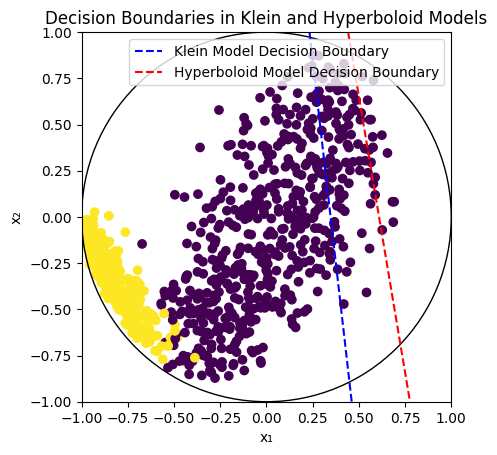

In [47]:
pm = manify.manifolds.ProductManifold(signature=[(-1, 2)])
X, y = pm.gaussian_mixture(cov_scale_means=.5, cov_scale_points=.05)

# Convert to numpy
X, y = X.numpy(), y.numpy()
y[y == 0] = -1  # Convert labels to -1 and 1

# Hyperboloid SVM training
w = train_hyperbolic_svm(X, y, C=1.0)
predictions = predict(w, X)
accuracy = np.mean(predictions == y)
print(f"Accuracy: {accuracy * 100:.2f}%")
print()

# Klein SVM training
X_klein = np.array([hyperboloid_to_klein(x) for x in X])
svm = LinearSVC(C=1.0, max_iter=1000)
svm.fit(X_klein, y)
predictions_klein = svm.predict(X_klein)
accuracy_klein = np.mean(predictions_klein == y)
print(f"Klein SVM Accuracy: {accuracy_klein * 100:.2f}%")
print()

comparisons = compare_weight_vectors(w, svm.coef_[0], svm.intercept_[0])
print(f"Cosine similarity: {comparisons['cosine_similarity']}")

plot_boundaries(X, y, w, svm.coef_[0], svm.intercept_[0] )

In [48]:
decision_function = svm.decision_function(X_klein)

# Calculate the margin (distance to the hyperplane)
# For points on the margin, this will be close to 1 or -1
margins = y * decision_function

# Find points close to the margin (support vectors)
epsilon = 1e-3  # Tolerance for numerical issues
support_indices_klein = np.where(np.abs(np.abs(margins) - 1) < epsilon)[0] 

margins_hyperboloid = y * [minkowski_inner_product(w, x) for x in X]
support_indices_hyperboloid = np.where(np.abs(np.abs(margins_hyperboloid) - 1) < epsilon)[0]

print(f"Support vectors in Klein model: {support_indices_klein}")
print(f"Support vectors in Hyperboloid model: {support_indices_hyperboloid}")

Support vectors in Klein model: [625]
Support vectors in Hyperboloid model: [ 65 380]


Naive Bayes Accuracy: 98.30%


Text(0.5, 1.0, 'Naive Bayes Decision Boundary')

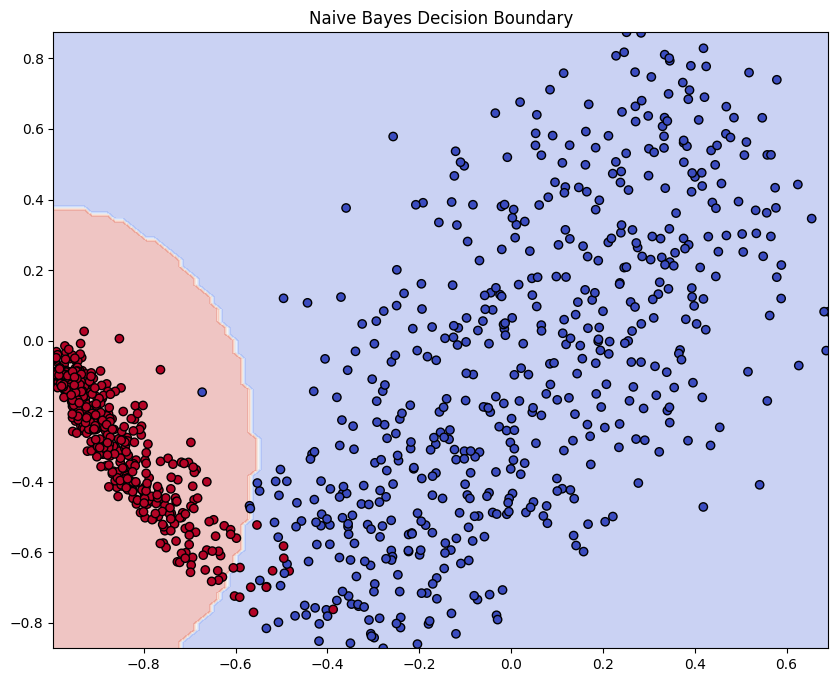

In [49]:
# Naive bayes
from sklearn.naive_bayes import GaussianNB as NB

y_zeros = y.clip(0, 1)

nb = NB()
nb.fit(X_klein, y_zeros)
predictions_nb = nb.predict(X_klein)
accuracy_nb = np.mean(predictions_nb == y_zeros)
print(f"Naive Bayes Accuracy: {accuracy_nb * 100:.2f}%")

# Plotting decision boundary for Naive Bayes
xx, yy = np.meshgrid(np.linspace(X_klein[:, 0].min(), X_klein[:, 0].max(), 101),
                     np.linspace(X_klein[:, 1].min(), X_klein[:, 1].max(), 101))
Z = nb.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_klein[:, 0], X_klein[:, 1], c=y, cmap='coolwarm', edgecolors='k')
plt.title('Naive Bayes Decision Boundary')